<a href="https://colab.research.google.com/github/Erhtric/NeuralQuestionGenerationNLP/blob/master/NeuralQG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Miscellanous

In [1]:
%load_ext tensorboard

This is the main file: its purpouse is to collect all the code coming from the coding pipeline.

## 0.1 Libraries

In [2]:
%%capture
!pip install datasets
#!pip install tflearn - batchnorm

In [3]:
import pandas as pd
import numpy as np
import json
import sklearn
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import re
import os
import typing
from typing import Any, Tuple, List, NamedTuple
import spacy
import gensim
import gensim.downloader as gloader
from gensim.models import KeyedVectors
#import seaborn as sns
from itertools import chain
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
#import tensorflow_addons as tfa
#import tensorflow_text as tf_text
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Layer, 
    Embedding, 
    LSTM, 
    Dense, 
    Bidirectional, 
    Input, 
    AdditiveAttention,
    Dropout)

# import keras_nlp
import nltk
#from nltk import punkt, pos_tag, ne_chunk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2 Directories

Commands to prepare the folder to accomodate data.

In [5]:
%cd /content/drive/MyDrive/NLP/Project/Testing folder/Eric
%pwd

# disable chained assignments to avoid annoying warning
pd.options.mode.chained_assignment = None 

/content/drive/.shortcut-targets-by-id/1cVw6eUwM-dRL9BhqtXULyOqeXDrYkwmH/NLP/Project/Testing folder/Eric


In [6]:
if not os.path.exists('./data'):
  print('Data folder does not exists. Creating it')
  os.makedirs('./data')

if not os.path.exists('./training_checkpoints'):
  print('Training checkpoint folder does not exists. Creating it')
  os.makedirs('./training_checkpoints')

if not os.path.exists('./logs'):
  print('Tensorboard Logs folder does not exists. Creating it')
  os.makedirs('./logs')

## 0.3 Configuration
This is for the `configuration.json` file, or something similar: 

In [7]:
batch_size = 256
units = 600

dataset_config = {
    'num_examples': 18896,
    # 'num_examples': 9448,
    'num_words_context': 45000,
    'num_words_question': 28000,
    'buffer_size': 32000,
    'batch_size': batch_size,
    'random_seed': 13,
}

model_config = {
    'enc_units': units,
    'dec_units': units,
    'max_length_context': None,
    'max_length_question': None,
    'dropout_rate': None,
    'regularizer': None,
}

path = {
    'training_json_path': "./data/training_set.json",
    'save_pkl_path': "./data/squadv2.pkl",
    'checkpoint_dir': "./training_checkpoints",
}


# 1. Dataset Definition

Things to do:
1. Add to each sentence $x$ a start of sequence `<SOS>` tag and end of sequence `<EOS>` tag,
2. Clean the sentences by removing special chars,
3. Perform other preprocessing steps,
4. Create a **vocabulary** with a word-to-index and index-to-word mappings by using a **tokenizer**, 
5. Extract the sentences that contain an answer and use them as input features, whereas the question will be our target
6. Pad each context to maximum length.

The resulting data that will be used hereinafter will be of type `tf.data.Dataset`. 

In [8]:
class Dataset(NamedTuple):
  """
  This class represent a a 3-way split processed dataset. 
  """
  # Reference :- https://github.com/topper-123/Articles/blob/master/New-interesting-data-types-in-Python3.rst
  train: tf.data.Dataset
  val: tf.data.Dataset
  test: tf.data.Dataset

class SQuAD:
  def __init__(self):
    self.random_seed = None
    self.squad_df = None
    self.preproc_squad_df = None
    self.tokenizer = None
    self.buffer_size = 0
    self.batch_size = 0

  def __call__(self,
           num_examples, 
           buffer_size, 
           batch_size, 
           random_seed,
           training_json_path,
           save_pkl_path,
           num_words_context=None,
           num_words_question=None,
           tokenized=True,
           pos_ner_tag=True,
           tensor_type=True):
    """The call() method loads the SQuAD dataset, preprocess it and optionally it returns 
    it tokenized. Moreover it also perform a 3-way split.

    Args:
        num_examples (int): number of examples to be taken from the original SQuAD dataset
        num_words (int): the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept. 
        buffer_size (int): buffer size for the shuffling operation
        batch_size (int): size of the batches
        tokenized (boolean): specifies if the context and question data should be both tokenized
        pos_ner_tag (boolean):
        tensor_type (boolean): 

    Returns (depending on the input parameters):
        pd.DataFrame: training dataset
        pd.DataFrame: validation dataset
        pd.DataFrame: testing dataset
          OR
        NamedTuple: dataset, (dict, dict, dict)
    """
    self.random_seed = random_seed
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.training_json_path = training_json_path
    self.save_pkl_path = save_pkl_path
    self.pos_ner_tag = pos_ner_tag
    self.max_length_context = 0
    self.max_length_question = 0

    # Load dataset from file
    self.load_dataset(num_examples)
    # Extract answer
    self.extract_answer()
    # Preprocess context and question
    self.preprocess()
    
    # Perform splitting
    X_train, y_train, X_val, y_val, X_test, y_test = self.split_train_val(self.preproc_squad_df)
    
    if self.pos_ner_tag: 
      pass

    # Initialize Tokenizer for the source: in our case the context phrases
    # alternatively TextVectorization 
    self.tokenizer_context = tf.keras.preprocessing.text.Tokenizer(filters='', 
                                                                   oov_token='<unk>',
                                                                   num_words=num_words_context)
    # initialize also for the target, namely the question phrases
    self.tokenizer_question = tf.keras.preprocessing.text.Tokenizer(filters='', 
                                                                   oov_token='<unk>',
                                                                   num_words=num_words_question)

    if tokenized:
      X_train_tokenized, word_to_idx_train_context = self.__tokenize_context(X_train, test=False)
      y_train_tokenized, word_to_idx_train_question = self.__tokenize_question(y_train, test=False)

      # update the max length for the other splits
      self.max_length_context = X_train_tokenized.context.iloc[0].shape[0]
      self.max_length_question = y_train_tokenized.iloc[0].shape[0]

      X_val_tokenized, word_to_idx_val_context = self.__tokenize_context(X_val, test=False)
      y_val_tokenized, word_to_idx_val_question = self.__tokenize_question(y_val, test=False)

      # The test set should handle the oov words as unkwown words
      X_test_tokenized, word_to_idx_test_context = self.__tokenize_context(X_test, test=True)
      y_test_tokenized, word_to_idx_test_question = self.__tokenize_question(y_test, test=True)

      word_to_idx_context = (word_to_idx_train_context, word_to_idx_val_context, word_to_idx_test_context)
      word_to_idx_question = (word_to_idx_train_question, word_to_idx_val_question, word_to_idx_test_question)
      
      if tensor_type:
        AUTOTUNE = tf.data.AUTOTUNE

        # Returns tf.Data.Dataset objects (tokenized)
        train_dataset = self.to_tensor(X_train_tokenized, y_train_tokenized)
        val_dataset = self.to_tensor(X_val_tokenized, y_val_tokenized)
        test_dataset = self.to_tensor(X_test_tokenized, y_test_tokenized)

        # Configure the dataset for performance
        train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
        val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
        test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

        dataset = Dataset(
            train=train_dataset, 
            val=val_dataset,
            test=test_dataset)

        return dataset, word_to_idx_context, word_to_idx_question
      else:
        # Returns pd.DataFrame objects (tokenized)
        return X_train_tokenized, y_train_tokenized, X_val_tokenized, y_val_tokenized, X_test_tokenized, y_test_tokenized
    else:
      return X_train, y_train, X_val, y_val, X_test, y_test

  def load_dataset(self, num_examples):
    """
    Extract the dataset from the json file. Already grouped by title.

    :param path: [Optional] specifies the local path where the training_set.json file is located

    :return
        - the extracted dataset in a dataframe format
    """
    if os.path.exists(self.save_pkl_path):
      print('File already exists! Loading from .pkl...\n')
      self.squad_df = pd.read_pickle(self.save_pkl_path)
      self.squad_df = self.squad_df[:num_examples]
    else:
      print('Loading from .json...\n')
      with open(self.training_json_path) as f:
          data = json.load(f)

      df_array = []
      for current_subject in data['data']:
          title = current_subject['title']

          for current_context in current_subject['paragraphs']:
              context = current_context['context']

              for current_question in current_context['qas']:
                  question = current_question['question']
                  id = current_question['id']

              for answer_text in current_question['answers']:
                    answer = answer_text['text']
                    answer_start = answer_text['answer_start']
                    record = { "id": id,
                                "title": title,
                                "context": context,
                                "question": question,
                                "answer_start": answer_start,
                                "answer": answer
                                }

              df_array.append(record)
      
      # Save file
      pd.to_pickle(pd.DataFrame(df_array), self.save_pkl_path)
      self.squad_df = pd.DataFrame(df_array)[:num_examples]

  def preprocess(self):
    df = self.squad_df.copy()

    # Pre-processing context
    context = list(df.context)
    preproc_context = []

    for c in context:
      c = self.__preprocess_sentence(c, question=False)
      preproc_context.append(c)
    
    df.context = preproc_context

    # Pre-processing questions
    question = list(df.question)
    preproc_question = []

    for q in question:
      q = self.__preprocess_sentence(q, question=True)
      preproc_question.append(q)
    
    df.question = preproc_question

    # Remove features that are not useful
    df = df.drop(['id'], axis=1)
    self.preproc_squad_df = df

  def __preprocess_sentence(self, sen, question):
    # Creating a space between a word and the punctuation following it
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sen = re.sub(r"([?.!,¿])", r" \1 ", sen)
    sen = re.sub(r'[" "]+', " ", sen)

    # Replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sen = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", sen)

    sen = sen.strip()

    # Adding a start and an end token to the sentence so that the model know when to 
    # start and stop predicting.
    # if not question: sen = '<SOS> ' + sen + ' <EOS>'
    sen = '<SOS> ' + sen + ' <EOS>'
    return sen

  def __answer_start_end(self, df):
    """
    Creates a list of starting indexes and ending indexes for the answers.

    :param df: the target Dataframe

    :return: a dataframe containing the start and the end indexes foreach answer (ending index is excluded).

    """
    start_idx = df.answer_start
    end_idx = [start + len(list(answer)) for start, answer in zip(list(start_idx), list(df.answer))]
    return pd.DataFrame(list(zip(start_idx, end_idx)), columns=['start', 'end'])

  def split_train_val(self, df, train_size=0.8):
    """
    This method splits the dataframe in training and test sets, or eventually, in training, validation and test sets.

    Args
        :param df: the target Dataframe
        :param random_seed: random seed used in the splits
        :param train_size: represents the absolute number of train samples
        :param val: boolean for choosing between a 3-way split or 2-way one.

    Returns:
        - Data and labels for training, validation and test sets if val is True 
        - Data and labels for training and test sets if val is False 

    """
    # Maybe we have also to return the index for the starting answer
    X = df.drop(['answer_start', 'question', 'answer'], axis=1).copy()
    idx = self.__answer_start_end(df)
    X['start'] = idx['start']
    X['end'] = idx['end']
    y = df['question']

    # In the first step we will split the data in training and remaining dataset
    splitter = GroupShuffleSplit(train_size=train_size, n_splits=2, random_state=self.random_seed)
    split = splitter.split(X, groups=X['title'])
    train_idx, rem_idx = next(split)

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_rem = X.iloc[rem_idx]
    y_rem = y.iloc[rem_idx]


    # Val and test test accounts for 10% of the total data. Both 5%.
    splitter = GroupShuffleSplit(train_size=train_size, n_splits=2, random_state=self.random_seed)
    split = splitter.split(X_rem, groups=X_rem['title'])
    val_idx, test_idx = next(split)

    X_val = X_rem.iloc[val_idx]
    y_val = y_rem.iloc[val_idx]

    X_test = X_rem.iloc[test_idx]
    y_test = y_rem.iloc[test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test

  def __tokenize_context(self, X, test):
    context = X.context
    if not test: self.tokenizer_context.fit_on_texts(context)
    context_tf = self.tokenizer_context.texts_to_sequences(context)

    if self.max_length_context != 0:
      context_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(context_tf, maxlen=self.max_length_context, padding='post')
    else:
      context_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(context_tf, padding='post')

    for i, _ in enumerate(context):
      X['context'].iloc[i] = context_tf_pad[i]

    # Add the padding
    self.tokenizer_context.word_index['<pad>'] = 0
    self.tokenizer_context.index_word[0] = '<pad>'

    return X, self.tokenizer_context.word_index

  def __tokenize_question(self, y, test):
    question = y
    if not test: self.tokenizer_question.fit_on_texts(question)
    question_tf = self.tokenizer_question.texts_to_sequences(question)
    
    if self.max_length_question != 0:
      question_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(question_tf, maxlen=self.max_length_question, padding='post')
    else:
      question_tf_pad = tf.keras.preprocessing.sequence.pad_sequences(question_tf, padding='post')

    for i, _ in enumerate(question):
      y.iloc[i] = question_tf_pad[i]

    # Add the padding
    self.tokenizer_question.word_index['<pad>'] = 0
    self.tokenizer_question.index_word[0] = '<pad>'

    return y, self.tokenizer_question.word_index

  def extract_answer(self):
    df = self.squad_df.copy()
    start_end = self.__answer_start_end(df)
    context = list(df.context)
    
    selected_sentences = []
    for i, par in enumerate(context):
      sentences = sent_tokenize(par)
      start = start_end.iloc[i].start
      end = start_end.iloc[i].end      
      right_sentence = ""
      context_characters = 0

      for j, sen in enumerate(sentences):
        sen += ' '
        context_characters += len(sen)
        # If the answer is completely in the current sentence
        if(start < context_characters and end <= context_characters):
          right_sentence = sen
          selected_sentences.append(right_sentence)
          break
        # the answer is in both the current and the next sentence
        if(start < context_characters and end > context_characters):
          right_sentence = sen + sentences[j+1]
          selected_sentences.append(right_sentence)
          break 

    self.squad_df.context = selected_sentences

  def to_tensor(self, X, y, train=True):
    X = X.context.copy()
    y = y.copy()

    # Reference:- https://www.tensorflow.org/api_docs/python/tf/data/Dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(list(X), tf.int64), 
         tf.cast(list(y), tf.int64)))
    if train: 
      dataset = dataset.shuffle(self.buffer_size).batch(self.batch_size, drop_remainder=True)
    else:
      dataset = dataset.batch(self.batch_size, drop_remainder=True)

    return dataset

By calling the `SQuAD` constructor we create a dataset handling object which will be useful for future operations.

In [9]:
dataset_creator = SQuAD()

## 1.1 Tensor Ready

This is the data produced that we are most interested in. As we can see we will have:
- a data structure `dataset` containing the training, validation and test set;
- a tuple containing the word-to-token mappings for the training, validation and test set respectively.

In [10]:
# Preprocessed dataset without tokenizing
%%time
dataset, word_to_idx_context, word_to_idx_question = dataset_creator(**dataset_config, 
                                                                     training_json_path=path['training_json_path'], 
                                                                     save_pkl_path=path['save_pkl_path'], 
                                                                     tokenized=True)

max_length_context = dataset.train.element_spec[0].shape[1]
max_length_question = dataset.train.element_spec[1].shape[1]

print(f'Sentences max lenght: {max_length_context}')
print(f'Questions max lenght: {max_length_question}')

File already exists! Loading from .pkl...

Sentences max lenght: 389
Questions max lenght: 40
CPU times: user 29.9 s, sys: 980 ms, total: 30.9 s
Wall time: 38.4 s


Accessing such `NamedTuple` data structure (cfr `dataset`) is pretty simple, namely in a:
1. tuple-way by accessing it like a list, e.g. `train = dataset[0]`,
2. object-way by calling the instance parameters, e.g. `train = dataset.train`.

The other two returned values are the word to index mappings for the context and question words respectively. In order to refer to a specific split simply call:
1. for the training dataset,
2. for the validation dataset,
3. for the test dataset,

In [11]:
print(f'Training vocab size for the context: {len(word_to_idx_context[0])}')
print(f'Training vocab size for the question: {len(word_to_idx_question[0])}')
print()
print(f'Validation vocab size for the context: {len(word_to_idx_context[1])}')
print(f'Validation vocab size for the question: {len(word_to_idx_question[1])}')
print()
print(f'Test vocab size for the context: {len(word_to_idx_context[2])}')
print(f'Test vocab size for the question: {len(word_to_idx_question[2])}')

Training vocab size for the context: 36668
Training vocab size for the question: 17290

Validation vocab size for the context: 40284
Validation vocab size for the question: 19021

Test vocab size for the context: 40284
Test vocab size for the question: 19021


In [12]:
print(f'Vocab size --- [Context]: {len(word_to_idx_context[1])} [Question]: {len(word_to_idx_question[1])}')

Vocab size --- [Context]: 40284 [Question]: 19021


# 2. GloVe and Embedding matrix

In [13]:
class GloVe:
  def __init__(self, embedding_dimension):
    self.embedding_dimension = embedding_dimension

    try:
      self.embedding_model = KeyedVectors.load(f'./data/glove_model_{self.embedding_dimension}')
    except FileNotFoundError:
      print('[Warning] Model not found in local folder, please wait...')
      self.embedding_model = self.load_glove()
      self.embedding_model.save(f'./data/glove_model_{self.embedding_dimension}')  
      print('Download finished. Model loaded!')

  def load_glove(self):
    """
    Loads a pre-trained GloVe embedding model via gensim library.

    We have a matrix that associate words to a vector of a user-defined dimension.
    """

    download_path = "glove-wiki-gigaword-{}".format(self.embedding_dimension)

    try:
      emb_model = gloader.load(download_path)
    except ValueError as e:
      print("Generic error when loading GloVe")
      print("Check embedding dimension")
      raise e

    emb_model = gloader.load(download_path)
    return emb_model

  def build_embedding_matrix(self, word_to_idx, vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the 
        dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, self.embedding_dimension), dtype=np.float32)
    oov_count = 0
    oov_words = []

    # For each word which is not present in the vocabulary we assign a random vector, otherwise we take the GloVe embedding
    for word, idx in tqdm(word_to_idx.items()):
      try:
        embedding_vector = self.embedding_model[word]
      except (KeyError, TypeError):
        oov_count += 1
        oov_words.append(word)
        embedding_vector = np.random.uniform(low=-0.5, 
                                             high=0.5, 
                                             size=self.embedding_dimension)

      embedding_matrix[idx] = embedding_vector
    
    print(f'\n[Debug] {oov_count} OOV words found!\n')
    return embedding_matrix, oov_words

The next step is to initialize the handler with the desidered `embedding_dimension`. Then to build the embedding matrix with the pre-trained GloVe embeddings simply call the `build_embedding_matrix` method.

In [14]:
%%time
# Initalize the handler for GloVe
glove_handler = GloVe(embedding_dimension=300)

# We will create the matrix by using only the words present in the training and validation set
embedding_matrix_context, oov_words_context = glove_handler.build_embedding_matrix(
    word_to_idx_context[2], 
    len(word_to_idx_context[2]))

embedding_matrix_question, oov_words_question = glove_handler.build_embedding_matrix(
    word_to_idx_question[2], 
    len(word_to_idx_question[2]))

100%|██████████| 40284/40284 [00:00<00:00, 239848.37it/s]



[Debug] 3607 OOV words found!



100%|██████████| 19021/19021 [00:00<00:00, 261743.22it/s]


[Debug] 1347 OOV words found!

CPU times: user 1.06 s, sys: 422 ms, total: 1.48 s
Wall time: 1.8 s


Convert both of them into tensor, but it is fine to also treat them as `numpy` array, still it is better to use the `tensorflow` fundamentals.

In [15]:
embedding_matrix_context = tf.convert_to_tensor(embedding_matrix_context)
embedding_matrix_question = tf.convert_to_tensor(embedding_matrix_question)

# 3. Encoder-Decoder Definition

In [16]:
example_context_batch, example_question_batch = next(iter(dataset.train))

## 3.1 Encoder
We will use a bidirectional LSTM to encode the sentence,
$$
\begin{align*}
\overrightarrow{b_t} &= \overrightarrow{\text{LSTM}}(x_t, \overrightarrow{b_{t-1}})\\
\overleftarrow{b_t} &= \overleftarrow{\text{LSTM}}(x_t, \overleftarrow{b_{t+1}})\\
\end{align*}
$$
where $\overrightarrow{b_t}$ is the hidden state at time step $t$ for the forward pass LSTM and $\overleftarrow{b_t}$ for the backward pass.

In [17]:
class Encoder(tf.keras.Model):
  def __init__(self, model_config, embedding_matrix, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    
    self.encoder_input = Input(shape=(model_config['max_length_context'],), 
                             batch_size = model_config['batch_size'], 
                             dtype=tf.int32, 
                             name='Context')
    self.embedding = Embedding(input_dim=embedding_matrix.shape[0],
                               output_dim=embedding_matrix.shape[1],
                               input_length=model_config['max_length_context'],
                               embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                               trainable=False,
                               mask_zero=True,
                               name='Context_embedding') 
    
    self.spatial_dropout = tf.keras.layers.SpatialDropout1D(model_config['dropout_rate'])

    self.bi_lstm = Bidirectional(LSTM(model_config['enc_units']//2, 
                                      return_sequences=True, 
                                      return_state=True,
                                      dropout=model_config['dropout_rate'],
                                      kernel_regularizer=tf.keras.regularizers.L2(model_config['regularizer'])), 
                                  name='Context_encoding',
                                  merge_mode='concat')

    self.concatenate = tf.keras.layers.Concatenate(axis=1, name='Merge') 

  def call(self, inputs, state=None, training=False):
    # 1. The input is a tokenized and padded sentence containing the answer from the context
    # 2. The embedding layer looks up for the embedding for each token, the mask is automatically produced
    vectors = self.embedding(inputs)

    vectors = self.spatial_dropout(vectors)

    # 3. The Bi-LSTM processes the embedding sequence forward and backward:
    #     output shape: ('batch', 'max_length_context', 'units')
    #     hidden state shape: fw ('batch', 'units//2'), bw ('batch', 'units//2')
    #     cell state shape: fw ('batch', 'units//2'), bw ('batch', 'units//2')
    output, forward_h, forward_c, backward_h, backward_c = self.bi_lstm(vectors, initial_state=state, training=training)

    # 4. Concatenate the forward and the backward states
    h = self.concatenate([forward_h, backward_h])
    c = self.concatenate([forward_c, backward_c])
    encoder_state = [h, c]

    # 5. Return the new sequence processed by the encoder and its state
    return [output, encoder_state]

  # Reference :- https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model
  def build_graph(self):
    return tf.keras.Model(inputs=self.encoder_input, outputs=self.call(self.encoder_input))
  
  def plot_model(self):
    return tf.keras.utils.plot_model(
        self.build_graph(),               
        show_shapes=True, 
        show_layer_names=True,  
        expand_nested=True                       
    )

### 3.1.1 Test the encoder stack



In [40]:
model_config = {
    'batch_size': 64,
    'enc_units': 256,
    'dec_units': 256,
    'max_length_context': dataset.train.element_spec[0].shape[1],
    'max_length_question': dataset.train.element_spec[1].shape[1],
    'dropout_rate': .3,
    'regularizer': 1e-2,
}

A simple example could be done by taking a single batch from the dataset.

In [41]:
# We need to encode the context, so we will pass the embedding matrix for the context
encoder = Encoder(model_config=model_config, embedding_matrix=embedding_matrix_context)
encoder_outputs, encoder_state = encoder(example_context_batch)

hidden_state, cell_state = encoder_state

print(f'Encoder output shape: (batch_size, max_length_context, units): {encoder_outputs.shape}')
print(f'Hidden state shape: (batch_size, units): {hidden_state.shape}')
print(f'Cell state shape: (batch_size, units): {cell_state.shape}')

Encoder output shape: (batch_size, max_length_context, units): (256, 389, 256)
Hidden state shape: (batch_size, units): (256, 256)
Cell state shape: (batch_size, units): (256, 256)


In [42]:
encoder.build_graph()
encoder.summary()

Model: "encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Context_embedding (Embeddin  (64, 389, 300)           12085200  
 g)                                                              
                                                                 
 spatial_dropout1d_1 (Spatia  (64, 389, 300)           0         
 lDropout1D)                                                     
                                                                 
 Context_encoding (Bidirecti  [(64, 389, 256),         439296    
 onal)                        (64, 128),                         
                              (64, 128),                         
                              (64, 128),                         
                              (64, 128)]                         
                                                                 
 Merge (Concatenate)         (64, 256)                 0 

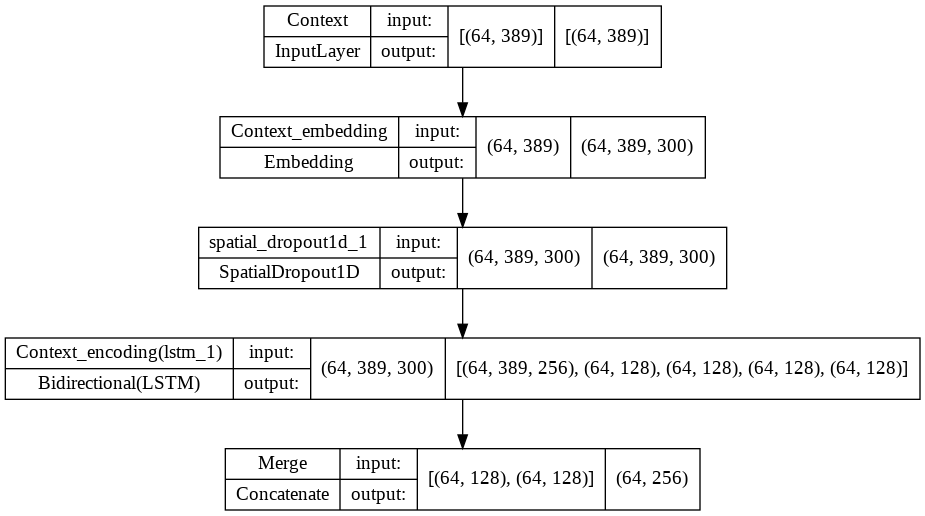

In [43]:
encoder.plot_model()

The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for a LSTM to return its state so that it can process a sequence over multiple calls.

## 3.2 Decoder

In [44]:
class Decoder(tf.keras.Model):
  def __init__(self, model_config, embedding_matrix, **kwargs):
    super(Decoder, self).__init__(**kwargs)
    
    # Attributes
    self.batch_size = model_config['batch_size']

    self.new_token_input = Input(shape=(1), 
                           batch_size=self.batch_size, 
                           name='Token_t')
    self.enc_output_input = Input(shape=(model_config['max_length_context'], model_config['enc_units']), 
                            batch_size=self.batch_size, 
                            name='Enc_output')
                        
    self.embedding = Embedding(input_dim=embedding_matrix.shape[0],
                               output_dim=embedding_matrix.shape[1],
                               embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                               trainable=False,  
                               mask_zero=True,
                               name='Question_embedding')
        
    self.lstm_layer_1 = LSTM(model_config['dec_units'], 
                           return_sequences=True,
                           return_state=np.True_,
                           dropout=model_config['dropout_rate'],
                           kernel_regularizer=tf.keras.regularizers.L2(model_config['regularizer']),
                           name='Decoding_question_1')
    
    self.lstm_layer_2 = LSTM(model_config['dec_units'], 
                           return_sequences=True,
                           return_state=True,
                           dropout=model_config['dropout_rate'],
                           kernel_regularizer=tf.keras.regularizers.L2(model_config['regularizer']),
                           name='Decoding_question_2')
    
    # self.attention = BahdanauAttention(decoder_config['dec_units'])
    # Additive attention layer, a.k.a. Bahdanau-style attention.
    self.attention = tf.keras.layers.AdditiveAttention(name='Attention_head')

    self.concatenate = tf.keras.layers.Concatenate(axis=-1, name='Merge')

    self.fc1 = Dense(model_config['dec_units']*2, activation=tf.keras.activations.tanh, use_bias=False, name='Dense_Wt')

    self.dropout = tf.keras.layers.Dropout(model_config['dropout_rate'])

    # Compute the logits
    self.decoder_logits = Dense(embedding_matrix.shape[0], use_bias=False, name='Logits_Ws')

  def call(self, inputs, state=None, training=False):
    new_token = inputs[0]
    enc_output = inputs[1]

    # 1. The embedding layer looks up for the embedding for each token, masks is automatically computed
    # vectors shape: (batch_size, 1, embedding_dimension)
    vectors = self.embedding(new_token)
    if tf.shape(vectors).shape == 2: vectors = tf.expand_dims(vectors, axis=1)

    # 2. Process one step with the LSTM
    # LSTM expects inputs of shape: (batch_size, timestep, feature)
    output, h, c = self.lstm_layer_1(vectors, initial_state=state, training=training)

    output, h, c = self.lstm_layer_2(output, initial_state=(h, c), training=training)

    # 4. Use the LSTM cell output as the query for the attention over the encoder output, that is the value.
    # The mask is automatically passed as argument by the keras backend.
    context_vector, attention_weights = self.attention([output, enc_output],
                                                       training=training,
                                                       return_attention_scores=True)

    # 5. Join the context_vector and cell output [ct; ht] shape: (batch t, value_units + query_units)
    output_and_context_vector = self.concatenate([context_vector, output])

    # at = tanh(Wt@[ht, ct])
    attention_vector = self.fc1(output_and_context_vector)

    attention_vector = self.dropout(attention_vector)

    # logits = softmax(Ws@at), it produces unscaled logits
    logits = self.decoder_logits(attention_vector)

    return [logits, attention_weights, (h, c)]

      # Reference :- https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model
  def build_graph(self):
    return tf.keras.Model(inputs=[self.new_token_input, self.enc_output_input], outputs=self.call([self.new_token_input, self.enc_output_input]))
  
  def plot_model(self):
    return tf.keras.utils.plot_model(
        self.build_graph(),               
        show_shapes=True, 
        show_layer_names=True,  
        expand_nested=True                       
    )

### 3.2.1 Test the decoder stack

The decoder will take as input:
1. `new_tokens`: the last token generated of shape `(batch_size, 1)`, namely the token obrained in the previous time step of the decoder (we will initialize the decoder with the `"<sos>"` token);
2. `enc_output`: this is the representation produced by the `Encoder` of shape `(batch_size, max_length_context, enc_units)`;
3. `mask`: this is the mask, that is a boolean tensor, indicating which tokens will be considered in the decoding of shape `(batch_size, max_length_context)`; 
4. `decoder_state`: the previous state of the decoder, namely the internal state of the decoder's LSTM (the paper suggests to input the hidden and cell state produced by the Bi-LSTM). The shape is `[(batch_size, enc_units), (batch_size, enc_units)]`.



In [45]:
decoder = Decoder(model_config=model_config, embedding_matrix=embedding_matrix_question)

In [46]:
# Convert the target sequence, and collect the "[START]" tokens
start_tag_index = word_to_idx_question[2]['<sos>']
first_token = tf.constant([[start_tag_index]] * dataset_config['batch_size'])

In [47]:
decoder_logits, attention_weights, decoder_state = decoder(inputs=[first_token, encoder_outputs], state=encoder_state)

hidden_dec_state, cell_dec_state = decoder_state

print(f'Logits shape: (batch_size, t, output_vocab_size) {decoder_logits.shape}')
print(f'Attention weights shape: (batch_size, t, max_length_context) {attention_weights.shape}')
print(f'Hidden state shape: (batch_size, dec_units) {hidden_dec_state.shape}')
print(f'Cell state shape: (batch_size, dec_units) {cell_dec_state.shape}')

Logits shape: (batch_size, t, output_vocab_size) (256, 1, 19021)
Attention weights shape: (batch_size, t, max_length_context) (256, 1, 389)
Hidden state shape: (batch_size, dec_units) (256, 256)
Cell state shape: (batch_size, dec_units) (256, 256)


In [48]:
decoder.build_graph()
decoder.summary()

Model: "decoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Question_embedding (Embeddi  (64, 1, 300)             5706300   
 ng)                                                             
                                                                 
 Decoding_question_1 (LSTM)  [(64, 1, 256),            570368    
                              (64, 256),                         
                              (64, 256)]                         
                                                                 
 Decoding_question_2 (LSTM)  [(64, 1, 256),            525312    
                              (64, 256),                         
                              (64, 256)]                         
                                                                 
 Attention_head (AdditiveAtt  ((64, 1, 256),           256       
 ention)                      (64, 1, 389))              

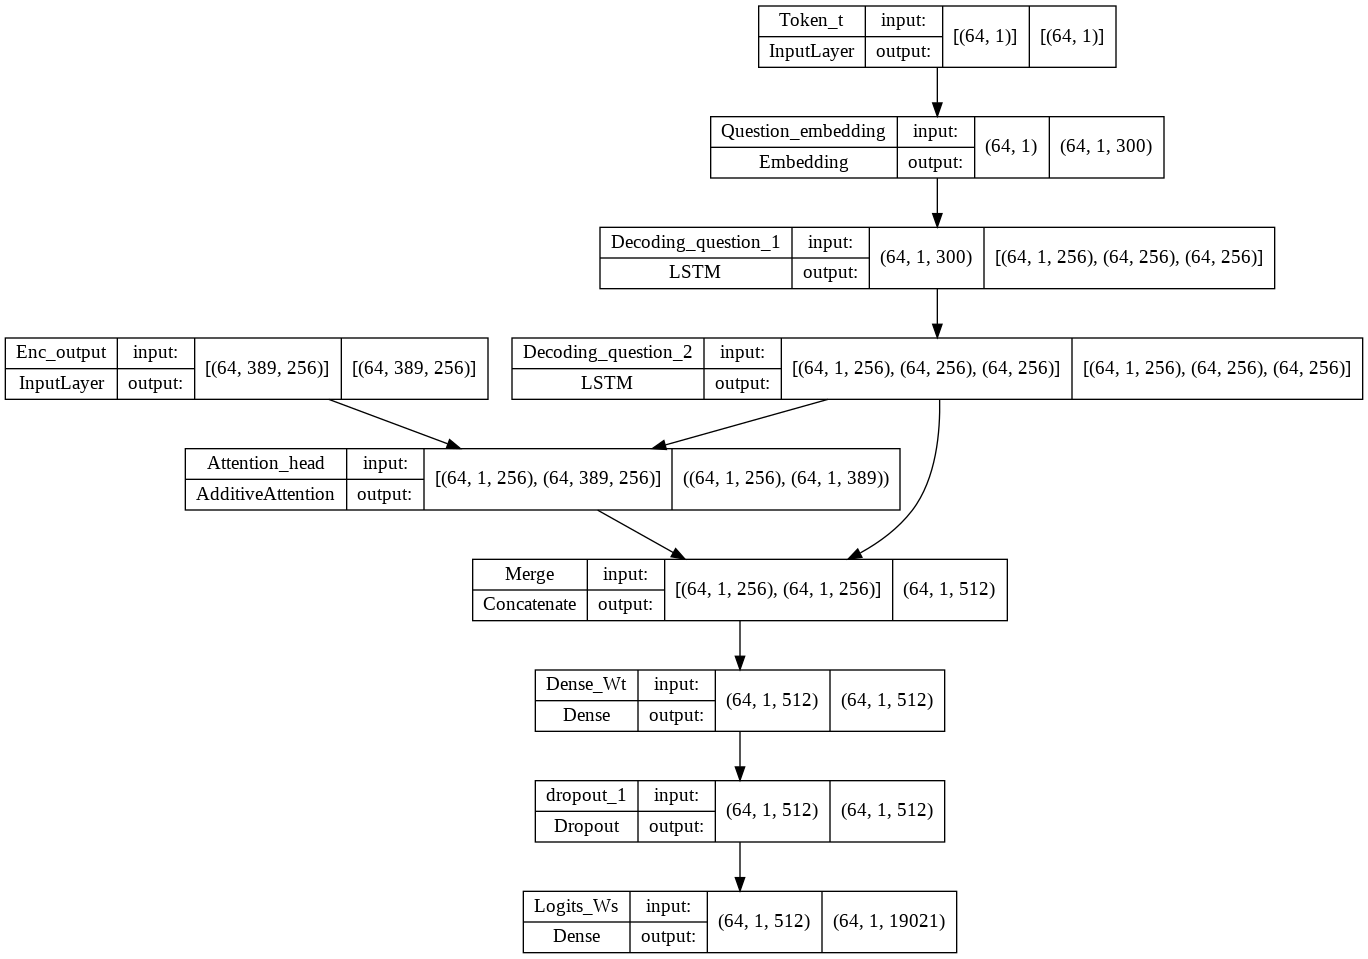

In [49]:
decoder.plot_model()

Moving on: this means that the decoder will produce a vector of unnormalized log probabilities (**logits**) associated to each vocabulary word. That is, a vector of logits $l_b \in \mathbb{R}^{\mathcal{V}}$ for each element $b$ in the batch, namely indicating the next probable token for a given sentence. 

Now we sample a token according to the logits computed by the decoder.

In [50]:
sampled_tokens = tf.random.categorical(
    logits=decoder_logits[:, 0, :],
    num_samples=1, 
    seed=dataset_config['random_seed'])
vocab = np.array(list(word_to_idx_question[2].keys()))

first_word = list(vocab[tf.squeeze(sampled_tokens, axis=-1).numpy()])
first_word[:5]

['publisher', 'absorbed', 'capilization', 'alloys', 'bumiller']

In [51]:
decoder_logits, _, _ = decoder([sampled_tokens, encoder_outputs], state=decoder_state)

sampled_tokens = tf.random.categorical(
    logits=decoder_logits[:, 0, :], 
    num_samples=1, 
    seed=dataset_config['random_seed'])
sampled_tokens = tf.squeeze(sampled_tokens, axis=-1).numpy()

first_word = list(vocab[sampled_tokens])
first_word[:5]

['waymarkers', 'anxiety', 'jolt', 'statues', 'taiwan']

Let's visualize the weights.

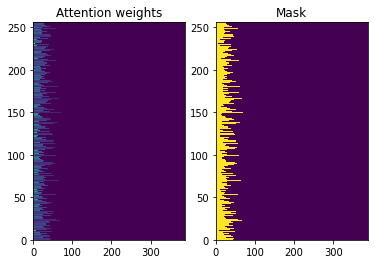

In [30]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_context_batch != 0)
plt.title('Mask')
plt.show()

Let's visualize the weights for only one sequence.

<Figure size 432x288 with 0 Axes>

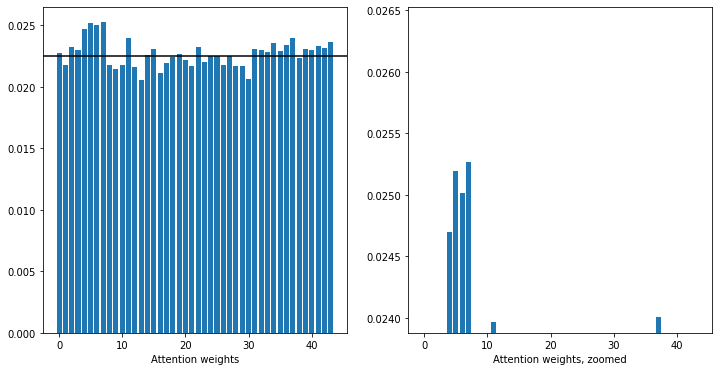

In [31]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

plt.show()

# 4. Question Generation Model

## 4.1 Tensorboard initialization

Remember to clear any logs from previous runs.

In [52]:
!rm -rf ./logs/

Set up summary writers to write the summaries to disk in a different logs directory.

In [53]:
log_dir = './logs'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = log_dir + '/gradient_tape/' + current_time + '/train'
test_log_dir = log_dir + '/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

## 4.2 Loss

The **QG** task is defined as finding $\hat{y}$ such that:
$$
\hat{y} = \arg{\max_y P(y|x)}  
$$
where $P(y|x)$ is the conditional log-likelihood of the predicted question sentence $y$ given the input $x$. Du et al. shown that the conditional probability could be factorized in:
$$
P(y|x) = \prod_{t=1}^{|y|} P(y_t|x, y_{<t})
$$
where the probability of each $y_t$ is predicted based on all the words that have been generated upon time $t$, namely $y_{<t}$.

This means that given a training corpus of sentence-question pairs $\mathcal{S} = \{(x^{(i)}, y^{(i)})\}_{i=1}^N$, the objective is to minimize the negative log-likelihood:
$$
\begin{align*}
\mathcal{L} &= - \sum_{i=1}^N \log P(y^{(i)}|x^{(i)}; \theta)\\
            &=  - \sum_{i=1}^N \sum_{j=1}^{|y^{(i)}|} \log P (y_j^{(i)}|x^{(i)}, y_{<j}^{(i)}; \theta)
\end{align*}
$$
We parameterize the probability of decoding each word $y_j$ by using an RNN:
$$
P(y_j|y_{<j}, s) = \text{softmax}(g(h_j))
$$
where $g(.)$ is a transition function that outputs a vocabulary-sized vector.

For more information see [here](https://stackoverflow.com/questions/47057361/how-do-i-mask-a-loss-function-in-keras-with-the-tensorflow-backend).

In [54]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred) 

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Sum the loss over the batch since reduction is set to NONE
    loss = tf.reduce_sum(loss)
    return loss

## 4.3 Training metrics

The metrics used during training will be:
1. **perplexity**, that is defined as $e^{H(p,q)}$ where $H(p,q)$ is the cross-entropy between $p$, that is the ground truth (labels), and $q$, that are unscaled probabilities distributions (logits), 
2. **masked accuracy**, namely an accuracy computed only on tokens which are not `<pad>`.

They will be implemented by exploiting the `Metric` object in `tensorflow`. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric) for more.

In [55]:
class Perplexity(tf.keras.metrics.Metric):
  def __init__(self, name='perplexity', **kwargs):
    super(Perplexity, self).__init__(name=name, **kwargs)
    self.scores = self.add_weight(name='perplexity_scores', initializer='zeros')

  def update_state(self, loss):
    """
    Reference :- https://www.surgehq.ai/blog/how-good-is-your-chatbot-an-introduction-to-perplexity-in-nlp
    """
    self.scores.assign(tf.exp(loss))

  def result(self): return self.scores
  def reset_state(self): self.scores.assign(0)

# Also the accuracy should mask the padding
class MaskedAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name='masked_accuracy',**kwargs):
    super(MaskedAccuracy, self).__init__(name=name, **kwargs)
    self.scores = self.add_weight(name='accuracy_scores', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    # We mask since we are not interested in the final accuracy score with the padding
    mask = tf.cast(tf.math.greater(y_true, 0), dtype=tf.float32)

    correct = tf.cast(tf.math.equal(y_true, y_pred), dtype=tf.float32)
    correct = tf.math.reduce_sum(mask * correct)
    total_legit = tf.math.reduce_sum(mask)

    self.scores.assign(correct / total_legit)

  def result(self): return self.scores
  def reset_state(self): self.scores.assign(0)

## 4.4 Callbacks

In [56]:
class GetEpochNumber(tf.keras.callbacks.Callback):
  def __init__(self, **kwargs) -> None:
    super(GetEpochNumber, self).__init__(**kwargs)

  def on_epoch_end(self, epoch, logs=None):
    self.model.epoch_number.assign_add(delta=1)

class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key) -> None:
    self.key = key
    self.logs = []

  def on_train_batch_ends(self, n, logs):
    self.logs.append(logs[self.key])

class CustomLearningRateScheduler(keras.callbacks.Callback):
  """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index (integer, indexed from 0) 
        and current learning rate as inputs and returns a new learning rate 
        as output (float).
  """
  def __init__(self):
    super(CustomLearningRateScheduler, self).__init__()
    self.schedule = self.lr_schedule

    self.LR_SCHEDULE = [
      # (epoch to start, learning rate) tuples
      (15, 1e-1),
      (23, 5e-2),
      # (12, 5e-5),
      # (14, 1e-5),
        ]

  def on_epoch_begin(self, epoch, logs=None):
    if not hasattr(self.model.optimizer, "lr"):
        raise ValueError('Optimizer must have a "lr" attribute.')
    # Get the current learning rate from model's optimizer.
    lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
    
    # Call schedule function to get the scheduled learning rate.
    scheduled_lr = self.schedule(epoch, lr)
    
    # Set the value back to the optimizer before this epoch starts
    tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
    print(f"\nEpoch {epoch+1}: Learning rate is {scheduled_lr}." )

  def lr_schedule(self, epoch, lr):
    """
    Helper function to retrieve the scheduled learning rate based on epoch.
    """
    if epoch < self.LR_SCHEDULE[0][0] or epoch > self.LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(self.LR_SCHEDULE)):
        if epoch == self.LR_SCHEDULE[i][0]:
            return self.LR_SCHEDULE[i][1]
    return lr

# Initialize the callbacks
batch_loss = BatchLogs('batch_loss')
perplexity = BatchLogs('perplexity')
accuracy = BatchLogs('accuracy')
lr_scheduler = CustomLearningRateScheduler()
epoch_counter = GetEpochNumber()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_perplexity', 
                                                  patience=8, 
                                                  mode='max', 
                                                  restore_best_weights=True) 

## 4.5 Model definition

The training step should:
1. Run the encoder on the `input_tokens` to get the `encoder_outputs`, `hidden_state` and `cell_state`. 

... complete

In [57]:
class CustomMasking(Layer):
    def __init__(self, mask_value=0, **kwargs):
        super(CustomMasking, self).__init__(**kwargs)
        self.supports_masking = True
        self.mask_value = mask_value
        self._compute_output_and_mask_jointly = True

    def compute_mask(self, inputs, mask=None):
        return tf.math.reduce_any(tf.math.not_equal(inputs, self.mask_value), 
                                  axis=list(range(2, len(inputs.shape))))

    def call(self, inputs):
        axes = list(range(2, len(inputs.shape)))
        boolean_mask = tf.math.reduce_any(tf.math.not_equal(inputs, self.mask_value),
                             axis=axes, keepdims=True)
        outputs = inputs * tf.cast(boolean_mask, inputs.dtype)
        # Compute the mask and outputs simultaneously.
        outputs._keras_mask = tf.squeeze(boolean_mask, axis=axes)  # pylint: disable=protected-access
        return outputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {'mask_value': self.mask_value}
        base_config = super(tf.keras.layers.Masking, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [58]:
class QGModel(tf.keras.Model):
  def __init__(self, model_config, embedding_matrix_context, embedding_matrix_question, **kwargs):
    """
    Prepare the model for the training. It builds the both the encoder and the decoder by
    exploiting the tf.keras.Model Sub-Classing API.
    Also it defines a wrapper to use the tf.function compilation for the tensorflow computational
    graph.
    """
    super(QGModel, self).__init__(**kwargs)
    self.context_input = Input(shape=(model_config['max_length_context']), batch_size=model_config['batch_size'])
    self.question_input = Input(shape=(model_config['max_length_question']), batch_size=model_config['batch_size'])
    self.masking = CustomMasking(mask_value=0)
    self.encoder = Encoder(model_config=model_config, embedding_matrix=embedding_matrix_context)
    self.decoder = Decoder(model_config=model_config, embedding_matrix=embedding_matrix_question)

    # Attributes
    self.max_length_question = model_config['max_length_question']
    self.batch_size = model_config['batch_size']
    # self.epoch_number = tf.Variable(initial_value=1, validate_shape=False, trainable=False, dtype=tf.int64)

    # Performance metrics
    self.train_accuracy = tf.keras.metrics.Accuracy()
    self.train_accuracy_sentence = MaskedAccuracy()
    self.test_accuracy = tf.keras.metrics.Accuracy()
    self.test_accuracy_sentence = MaskedAccuracy()
    self.train_perplexity = Perplexity()
    self.test_perplexity = Perplexity()

    # Loss tracker, resets at the beginning of each epoch
    self.train_loss_tracker = tf.keras.metrics.Mean(name='loss')
    self.test_loss_tracker = tf.keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    # We list our `Metric` objects here so that `reset_states()` can be called 
    # automatically at the start of each epoch or at the start of `evaluate()`.
    # If you don't implement this property, you have to call # `reset_states()` 
    # yourself at the time of your choosing.
    return [self.train_loss_tracker, self.train_accuracy, self.train_perplexity, self.train_accuracy_sentence,
            self.test_loss_tracker, self.test_accuracy, self.test_perplexity, self.test_accuracy_sentence]

  def call(self, inputs, training=False):
    """
    It performs a forward pass. Calls the model on new inputs and returns the outputs as tensors.
    """
    context, question = inputs

    context = self.masking(context)
    question = self.masking(question)

    # We collect the question predicted by the decoder, the first character is the starting token
    y_pred = tf.fill([self.batch_size, 1], question[0][0])
    
    # Keep a loss tracking value
    if training:
      self.train_loss_tracker.reset_state()
    else:
      self.test_loss_tracker.reset_state()
    
    # Set the loss 
    loss = tf.constant(0.0)
    
    # Encode the input, that is the context
    encoder_outputs, encoder_state = self.encoder(context, training=training)

    # The decoder should be initialized with the encoder last state 
    decoder_state = encoder_state

    t = 0
    # We have to run the decoder for all the length of the question 
    while t < (self.max_length_question - 1):
      # We have to pass two tokens:
      #   1. the token at time step t, namely the token in which we need to start run the decoder 
      #   2. the token at time step t+1, that is the next token in the sequence that needs to be compared with
      # Note that: at the start of the question the new_token will be start-of-seq tag
      new_token = tf.gather(question, t, axis=1)
      target_token = tf.gather(question, t+1, axis=1)

      # Here we call the decoder in order to produce the token at time step t+1, it returns,
      #   1. the partial loss for the predicted token,
      #   2. the new decoder state,
      #   3. the predicted token at time step t+1
      step_loss, decoder_state, token_pred = self.step_decoder(
          (new_token, target_token),
          encoder_outputs,
          decoder_state, 
          training=training)

      # Concatenate the predicted token to the already obtained question
      y_pred = tf.concat([y_pred, token_pred], axis=1)

      # Each partial loss contributes to the total loss
      loss = loss + step_loss
      t = t + 1

    # Since we have computed a cumulated partial scores of the losses produced 
    # at each decoder step we then average for the number of elements that are 
    # not padding
    loss = loss / tf.math.reduce_sum(tf.cast(question != 0, dtype=loss.dtype))

    return y_pred, loss
  
  def step_decoder(self, tokens, encoder_outputs, decoder_state, training):
    """
    Run a single iteration of the decoder and computers the incremental loss between the
    produced token and the token in the target input.
    """
    new_token = tokens[0]
    
    # Run the decoder one time, this will return the logits for the token at timestep t+1 for the entire batch
    decoder_logits, _, decoder_state = self.decoder([new_token, encoder_outputs], state = decoder_state, training=training)
  
    y_true = tf.expand_dims(tokens[1], axis=1)
    y_pred = decoder_logits

    # Compare the produced logits with the true token
    step_loss = self.loss(y_true=y_true, y_pred=y_pred)

    # Greedily extract the word that has the maximum value in the produced logits
    y_pred = tf.cast(tf.math.argmax(y_pred, axis=-1), dtype=tf.int64)

    if training:
      self.train_accuracy.update_state(y_true=y_true, y_pred=y_pred, sample_weight=tf.cast((y_true != 0), tf.int32))
    else:
      self.test_accuracy.update_state(y_true=y_true, y_pred=y_pred, sample_weight=tf.cast((y_true != 0), tf.int32))

    return step_loss, decoder_state, y_pred
  
  @tf.function
  def train_step(self, inputs):
    """
    Optimization step for a batch.
    """
    context, question = inputs
    with tf.GradientTape() as tape:
      # Computes the forward pass: it returns the predicted question and the loss value averaged over the batch
      y_pred, loss = self(inputs, training=True)

    self.train_loss_tracker.update_state(loss)

    # Compute gradients
    tr_variables = self.trainable_variables
    grads = tape.gradient(loss, tr_variables)

    # Apply some clipping (by norm) as done in the paper and update the weights
    ads = [tf.clip_by_norm(g, 5.0) for g in grads]
    self.optimizer.apply_gradients(zip(grads, tr_variables))

    # Compute metrics
    self.train_perplexity.update_state(loss)
    self.train_accuracy_sentence.update_state(y_true=question, y_pred=y_pred)

    # Log to tensorboard
    # with train_summary_writer.as_default():
    #   tf.summary.scalar('train_loss', self.train_loss_tracker.result(), step=self.epoch_number)
    #   tf.summary.scalar('train_perplexity', self.train_perplexity_metric.result(), step=self.epoch_number)
    #   tf.summary.scalar('train_accuracy', self.train_accuracy_metric.result(), step=self.epoch_number)

    return {m.name: m.result() for m in self.metrics[:4]}

  @tf.function
  def test_step(self, inputs):
    """
    The logic for one evaluation step. This function should contain the mathematical logic 
    for one step of evaluation. This typically includes the forward pass, 
    loss calculation, and metrics updates.

    Called when at each epoch's end to validate on the validation data given.
    """
    context, question = inputs

    context = self.masking(context)
    question = self.masking(question)

    # Computes a forward pass with training set to False
    y_pred, loss = self(inputs, training=False)
    self.test_loss_tracker.update_state(loss)

    # Compute metrics
    self.test_perplexity.update_state(loss)
    self.test_accuracy_sentence.update_state(y_true=question, y_pred=y_pred)

    return {m.name: m.result() for m in self.metrics[4:]}

  # # # Reference :- https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model
  def build_graph(self):
    return tf.keras.Model(inputs=[self.context_input, self.question_input], outputs=self.call([self.context_input, self.question_input]))
  
  def plot_model(self):
    return tf.keras.utils.plot_model(
        self.build_graph(),               
        show_shapes=True, 
        show_layer_names=True,  
        expand_nested=True                       
    )


# Utility function in order to build the compiled model
def build_model(model_config,
                embedding_matrix_context, 
                embedding_matrix_question, 
                compile_info):
  model = QGModel(model_config,
                  embedding_matrix_context=embedding_matrix_context,
                  embedding_matrix_question=embedding_matrix_question)
  
  model.compile(**compile_info)
  return model

# 5. Train the model

In [59]:
def train_model(model,
                dataset: NamedTuple,
                training_info):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param dataset: the split dataset
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print("Start training \nParameters: {}".format(training_info))
    history = model.fit(dataset.train,
                        validation_data=dataset.val,
                        **training_info)
    print("Training completed")
    return history, model

In [61]:
training_info = {
    'verbose': 1,
    'epochs': 5,
    'batch_size': dataset_config['batch_size'],
    'callbacks': [
                  batch_loss,
                  perplexity,
                  accuracy,
                  # lr_scheduler,
                  # tensorboard_callback,
                  # epoch_counter,
                  # early_stopping
                  ],
}

model_config = {
    'batch_size': dataset_config['batch_size'],
    'enc_units': 256,
    'dec_units': 256,
    'max_length_context': dataset.train.element_spec[0].shape[1],
    'max_length_question': dataset.train.element_spec[1].shape[1],
    'dropout_rate': 0.3,
    'regularizer': 1e-4,
}

compile_info = {
    'loss': MaskedLoss(),
    'optimizer': keras.optimizers.Adam(learning_rate=1e-3), 
}

qg_model = build_model(model_config, embedding_matrix_context, embedding_matrix_question, compile_info)

In [62]:
history, qg_model = train_model(model=qg_model, 
                                dataset=dataset,
                                training_info=training_info)

Start training 
Parameters: {'verbose': 1, 'epochs': 5, 'batch_size': 256, 'callbacks': [<__main__.BatchLogs object at 0x7f507b2f7350>, <__main__.BatchLogs object at 0x7f507b2f7a90>, <__main__.BatchLogs object at 0x7f507aefd350>]}
Epoch 1/5
59/59 [==============================] - 209s 1s/step - loss: 5.8595 - accuracy: 0.1138 - perplexity: 350.5324 - masked_accuracy: 0.2046 - val_loss: 5.7414 - val_accuracy: 0.1559 - val_perplexity: 311.4963 - val_masked_accuracy: 0.2217
Epoch 2/5
59/59 [==============================] - 53s 897ms/step - loss: 5.5146 - accuracy: 0.2102 - perplexity: 248.2870 - masked_accuracy: 0.2819 - val_loss: 5.5033 - val_accuracy: 0.2339 - val_perplexity: 245.4908 - val_masked_accuracy: 0.2915
Epoch 3/5
59/59 [==============================] - 53s 901ms/step - loss: 5.3507 - accuracy: 0.2372 - perplexity: 210.7603 - masked_accuracy: 0.2920 - val_loss: 5.4283 - val_accuracy: 0.2425 - val_perplexity: 227.7543 - val_masked_accuracy: 0.2988
Epoch 4/5
59/59 [==========

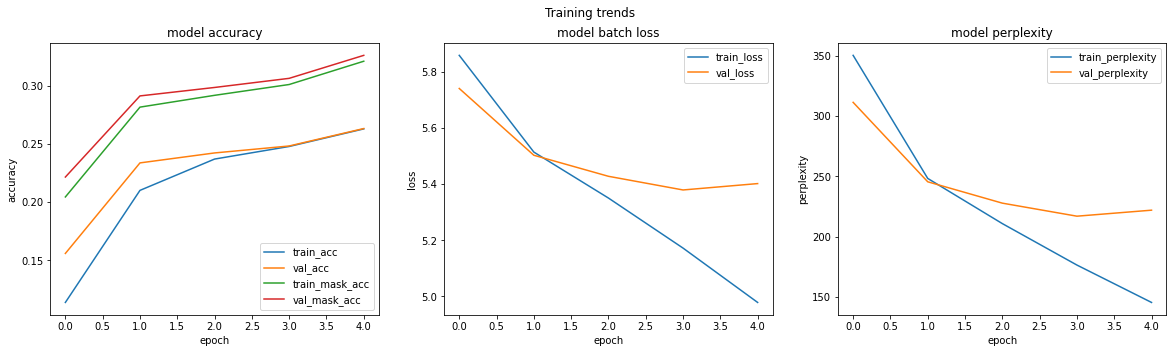

In [68]:
def plot_history(hist):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))

    fig.suptitle('Training trends')
    axs[0].plot(hist.history['accuracy'])
    axs[0].plot(hist.history['val_accuracy'])
    axs[0].plot(hist.history['masked_accuracy'])
    axs[0].plot(hist.history['val_masked_accuracy'])
    axs[0].set_title("model accuracy")
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train_acc', 'val_acc', 'train_mask_acc', 'val_mask_acc'], loc='best')
    
    axs[1].plot(hist.history['loss'])
    axs[1].plot(hist.history['val_loss'])
    axs[1].set_title("model batch loss")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train_loss', 'val_loss'], loc='best')

    axs[2].plot(hist.history['perplexity'])
    axs[2].plot(hist.history['val_perplexity'])
    axs[2].set_title("model perplexity")
    axs[2].set_ylabel('perplexity')
    axs[2].set_xlabel('epoch')
    axs[2].legend(['train_perplexity', 'val_perplexity'], loc='best')

    plt.show()

  
plot_history(history)

In [ ]:
#%tensorboard --logdir ./logs/gradient_tape

#6. Inference and Evaluation for QG


## 6.1 Evaluation metrics

To evaluate our model we will use the **BLEU-$n$** and **METEOR** metrics imported from [Hugginface](https://huggingface.co/datasets)([github/datasets](https://github.com/huggingface/datasets/tree/master/metrics)). For more information the single metrics please refer to the official [repository](https://github.com/huggingface/datasets/tree/master/metrics).



In [67]:
from datasets import load_metric

In [68]:
class BLEU(keras.metrics.Metric):
  def __init__(self, name=f"bleu_metric", **kwargs):
    """
    Initialize the metric object for computing BLEU-n.
    """
    super(BLEU, self).__init__(name=name, **kwargs)
    # Reference :- https://github.com/huggingface/datasets/tree/master/metrics/bleu
    self.bleu = load_metric("bleu")
    self.scores_1 = self.add_weight(name=f"bleu1_scores", initializer="zeros")
    self.scores_2 = self.add_weight(name=f"bleu2_scores", initializer="zeros")
    self.scores_3 = self.add_weight(name=f"bleu3_scores", initializer="zeros")
    self.scores_4 = self.add_weight(name=f"bleu4_scores", initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight=None):
    results = self.bleu.compute(predictions=y_pred, references=y_true, max_order=1)
    self.scores_1.assign(tf.constant(results['bleu']))

    results = self.bleu.compute(predictions=y_pred, references=y_true, max_order=2)
    self.scores_2.assign(tf.constant(results['bleu']))

    results = self.bleu.compute(predictions=y_pred, references=y_true, max_order=3)
    self.scores_3.assign(tf.constant(results['bleu']))

    results = self.bleu.compute(predictions=y_pred, references=y_true, max_order=4)
    self.scores_4.assign(tf.constant(results['bleu']))

  def result(self):
    return (self.scores_1, self.scores_2, self.scores_3, self.scores_4)

  def reset_state(self):
    # The state of the metric will be reset at the start of each epoch.
    self.scores_1.assign(0.0)
    self.scores_2.assign(0.0)
    self.scores_3.assign(0.0)
    self.scores_4.assign(0.0)

# metric = BLEU1()
# y_pred = [
#      ["hello", "there", "general", "kenobi"],
#      ["how", "are" "you"]]
# y_true = [
#      [["hello", "there", "general", "kenobi"]],
#      [["how", "are", "you"]]
#  ]
# metric.update_state(y_true, y_pred)

class METEOR(keras.metrics.Metric):
  def __init__(self, name=f"meteor_metric", **kwargs):
    """
    Initialize the metric object for computing METEOR.
    """
    super(METEOR, self).__init__(name=name, **kwargs)
    # Reference :- https://github.com/huggingface/datasets/tree/master/metrics/meteor
    self.meteor = load_metric("meteor")
    self.scores = self.add_weight(name=f"meteor_scores", initializer="zeros", dtype=tf.float64)

  def update_state(self, y_true, y_pred, sample_weight=None):
    results = self.meteor.compute(predictions=y_pred, references=y_true)
    self.scores.assign(tf.constant(results['meteor'], dtype=tf.float64))

  def result(self):
    return self.scores

  def reset_state(self):
    # The state of the metric will be reset at the start of each epoch.
    self.scores.assign(0.0)

## 6.2 Inference for QG
In this section we will provide the class and the methods for the inference part. More specifically, both auxiliary and inferencing methods:
1. `token_to_string()`:
2. `string_to_token()`:
3. `create_mask()`:
4. `temperature_sampling()`:
5. `generate_question()`:

In [73]:
class QuestionGenerator(tf.Module):
  def __init__(self, model, tokenizer, use_tf_function):
    self.model = model
    self.encoder = model.encoder
    self.decoder = model.decoder

    # The tokenizer will be used for the 
    self.tokenizer = tokenizer
   
    self.result_tokens = None
    self.result_text = None
    self.token_mask = self.create_mask()

    self.start_idx = tokenizer.word_index['<sos>']
    self.end_idx = tokenizer.word_index['<eos>']
    self.use_tf_function = False

    # Metrics
    # These ones are computed and refreshed for each batch
    self.bleu_metric_batch = BLEU()
    self.meteor_metric_batch = METEOR()
    
    # These ones are the mean value among all the batches
    self.bleu_metric = tf.keras.metrics.Mean(name='bleu_mean')
    self.meteor_metric = tf.keras.metrics.Mean(name='meteor_mean')

  def token_to_string(self, result_tokens: tf.Tensor):  
    """
    This method converts token IDs to text by using a given mapping.
    """
    list_tokens = result_tokens.numpy().tolist()
    list_text = self.tokenizer.sequences_to_texts(list_tokens)
    
    # list_text = tf.convert_to_tensor([list_text])
    # result_text = tf.strings.reduce_join(list_text, axis=0, separator=' ')
    # result_text = tf.strings.strip(result_text)
    result_text = [s.split() for s in list_text]

    self.result_tokens = result_tokens
    self.result_text = result_text
    return result_text

  def string_to_token(self, result_str: tf.Tensor):
    """
    This method converts texts to token IDs by using a given mapping.
    """  
    list_str = [s.decode("utf-8") for s in result_str.numpy().tolist()]
    list_tokens = self.tokenizer.texts_to_sequences(list_str)
    list_tokens = tf.convert_to_tensor(list_tokens, dtype=tf.int64)
    result_tokens = tf.squeeze(tf.split(list_tokens, num_or_size_splits=list_tokens.shape[0], axis=0), axis=1)

    return result_tokens
  
  def create_mask(self):
    """
    This method creates a mask for the padding, the unknwon words and the start/ending tokens.
    """
    masked_words = ['<pad>', '<unk>', '<sos>', '<eos>']
    token_mask_ids = [self.tokenizer.word_index[mask] for mask in masked_words]

    token_mask = np.zeros(shape=(len(self.tokenizer.word_index)+1,), dtype=bool)
    token_mask[np.array(token_mask_ids)] = True
    return token_mask

  def evaluate(self, inputs, max_length, temperature):
    for (context, question_true) in tqdm(inputs):
      question_true = self.token_to_string(question_true)
      prediction = self.predict_step(inputs=context, max_length=max_length, return_attention=False, temperature=temperature)
      question_pred = prediction['text']

      self.meteor_metric_batch.update_state(y_true=[question_true], y_pred=[question_pred])

      print('Comparing')
      print('Question true', question_true)
      print('Question predicted', question_pred)
      print('Score obtained', self.meteor_metric_batch.result())

      # Produce the mean over the batches
      self.meteor_metric.update_state(self.meteor_metric_batch.result())

    return {'meteor': self.meteor_metric.result().numpy()}

  def predict(self, inputs, max_length, return_attention=False, temperature=0.):
    """
    Generates output predictions for the input samples.
    In addition it could also return the associated attention weights.

    It returns a list of dictionaries.
    """
    results = []
    for (context, _) in inputs:
      results.append(self.predict_step(inputs=context, 
                                        max_length=max_length, 
                                        return_attention=return_attention, 
                                        temperature=temperature))

    return results

  def predict_step(self, inputs, max_length, return_attention, temperature):
    # Similarly for what it has been done in the train step

    encoder_output, encoder_state = self.encoder(inputs)
    decoder_state = encoder_state

    # Generate the first token of each sentence, that is the <sos> token
    new_token = tf.fill([self.model.batch_size, 1], self.start_idx)

    result_tokens = []
    attention = []
    done = tf.zeros(shape=(self.model.batch_size, 1), dtype=tf.bool)
    
    for _ in range(max_length):
      # Decode the token at the next timestep
      decoder_logic, attention_weights, decoder_state = self.decoder([new_token, encoder_output], state=decoder_state)
      
      attention.append(attention_weights)

      # Sample the new token accordingly to the distribution produced by the decoder
      new_token = self.temperature_sampling(decoder_logits, temperature)

      # if a sequence has reached <eos> set it as done
      done = done | (new_token == self.end_idx)
      # Once a sequence is done it only produces 0-padding.
      new_token = tf.where(done, tf.constant(0, dtype=tf.int64), new_token)

      result_tokens.append(new_token)

      if tf.reduce_all(done):
        break

    # MISSING
    result_tokens = tf.concat(result_tokens, axis=-1)
    # result_text = self.token_to_string(result_tokens)
    result_text = result_tokens

    attention_stack = tf.concat(attention, axis=-1)

    # HANDLING UNK WORDS

    if return_attention:
      attention_stack = tf.concat(attention, axis=1)
      return {'text': result_text, 'attention': attention_stack}
    else:
      return {'text': result_text}

  def temperature_sampling(self, logits, temperature):
    """
    For the temperature choice see here:
      Reference :- https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/
    """
    # First of all we use broadcast the generated mask to the expected logits' shape
    # token_mask shape: (batch_size, timestep, vocab_size)
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # The logits for all the tokens that have to not be used are set to -1.0
    #logits = tf.where(token_mask, -1.0, logits)

    # Freezing function
    # Higher temperature -> greater variety
    # Lower temperature -> grammatically correct
    if temperature == 0.0:
      # the freezing function is the argmax, behaving like a greedy search
      new_token = tf.argmax(logits, axis=-1)
    else:
      # the freezing function now scales the logits.
      # for temperature == 1.0 is the identity function
      logits = tf.squeeze(logits, axis=1)
      new_token = tf.random.categorical(logits / temperature, num_samples=1)
    return new_token

In [74]:
qg_evaluator = QuestionGenerator(model=qg_model,
                         tokenizer=dataset_creator.tokenizer_question, 
                         use_tf_function=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [ ]:
#%%time
#pred = qg_evaluator.evaluate(dataset.test, 50, 0.5)

In [75]:
y_pred = qg_evaluator.predict(dataset.test, 10)

In [ ]:
next(iter(dataset.test))[1][0]

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([   2,    6,   11,    5,  427,  521,  813,    8, 4443,    4,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>

In [76]:
y_pred[0]['text'][0]

<tf.Tensor: shape=(10,), dtype=int64, numpy=
array([17499, 17499, 17499, 17499, 17499, 17499, 17499, 17499, 17499,
       17499])>